# Grids

This example allows us to explore a HDF5 grid file, and load the corresponding Grid object. We first load some common modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

We can then import the `Grid` object from synthesizer.

In [2]:
from synthesizer.grid import Grid

This object takes the location of the grids on your system (`grid_dir`) and the name of the grid you wish to load `grid_name`). here we load a simple test grid provided with the module (hence the relative path).

In [3]:
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"

grid = Grid(grid_name, grid_dir=grid_dir)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3
  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7
  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1
 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11. ] 
metallicity: [1.0e-05 1.0e-04 1.0e-03 2.0e-03 3.0e-03 4.0e-03 6.0e-03 8.0e-03 1.0e-02
 1.4e-02 2.0e-02 3.0e-02 4.0e-02] 
CMB: None 
T_floor: 100 
abundance_scalings_carbon: GalacticConcordance 
abundance_scalings_nitrogen: GalacticConcordance 
alpha: 0.0 
axes: ['log10age' 'metallicity'] 
axes_alternative: ['log10ages' 'metallicities'] 
cloudy_version: c23.01 
constant_density: True 
cosmic_rays: True 
depletion_model: Jenkins2009_Gunasekera2021 
depletion_scale: 0.5 
geometry: spherical 
grains: Orion 
hydrogen_density: 1000.0 
incident_axes: ['log10age' 'metallicity'] 
ionisation_parameter_model: ref 
iterate_to_convergence: True 
log10age: [ 6.   6.1  6.2  6.3  6.4  6.5 

A `Grid` can also take various arguments to limit the size of the grid by isolating the `Grid` to a region of interest. This is particularly useful when making a large number of spectra from a high resolution `Grid` where the memory footprint can become large.

### Passing a wavelength array

If you only care about a grid of specific wavelength values you can pass this array and the `Grid` will automatically be interpolated onto the new wavelength array using `spectres`.

In [4]:
# Define a new set of wavelengths
new_lams = np.logspace(2, 5, 1000)

# Create a new grid
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=new_lams)
print(grid.shape)

(51, 13, 1000)


# Passing wavelength limits

If you don't want to modify the underlying grid resolution but only care about a specific wavelength range you can pass limits to truncate the grid at.

In [5]:
# Create a new grid
grid = Grid(grid_name, grid_dir=grid_dir, lam_lims=(10**3, 10**4))
print(grid.shape)

(51, 13, 691)


You can also pass a `FilterCollection` to isolate the grid to the filter curves you care about. For more details see the the [filter docs](../filters.ipynb).

## Plot a single grid point

We can plot the spectra at the location of a single point in our grid. First, we choose some age and metallicity

In [6]:
# Return to the unmodified grid
grid = Grid(grid_name, grid_dir=grid_dir)

log10age = 6.0  # log10(age/yr)
Z = 0.01  # metallicity

We then get the index location of that grid point for this age and metallicity

In [7]:
grid_point = grid.get_grid_point((log10age, Z))

We can then loop over the available spectra (contained in `grid.spec_names`) and plot

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Text(0, 0.5, '$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$')

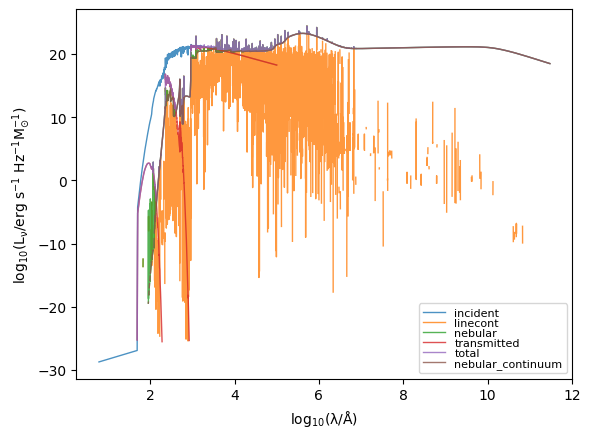

In [8]:
for spectra_id in grid.available_spectra:
    # get Sed object
    sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
    plt.plot(
        np.log10(sed.lam), np.log10(sed.lnu), lw=1, alpha=0.8, label=spectra_id
    )

plt.legend(fontsize=8, labelspacing=0.0)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")

## Plot ionising luminosities

We can also plot properties over the entire age and metallicity grid, such as the ionising luminosity. 

In the examples below we plot ionising luminosities for HI and HeII

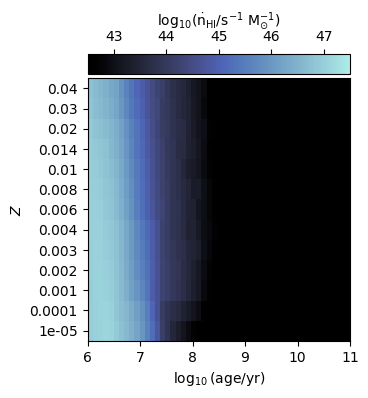

In [9]:
fig, ax = grid.plot_specific_ionising_lum(ion="HI")

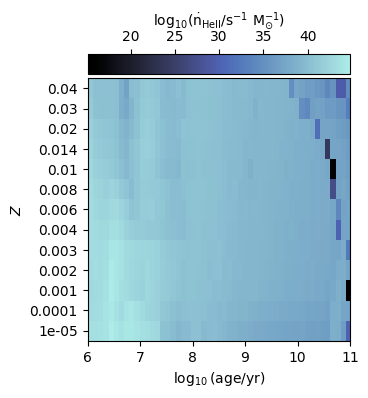

In [10]:
fig, ax = grid.plot_specific_ionising_lum(ion="HeII")

## 3D grids

This functionality is currently in development - come back soon!

In [11]:
# grid_name = 'test_grid3D'

# grid = Grid(grid_name, grid_dir=grid_dir)
# print(grid)

## Resampling Grids

If you want to resample a grid after istantiation you can apply the `intrep_spectra` method.

In [12]:
# Define a new set of wavelengths
new_lams = np.logspace(2, 5, 10000)

print("The old grid had dimensions:", grid.spectra["incident"].shape)

# Get the grid interpolated onto the new wavelength array
grid.interp_spectra(new_lam=new_lams)

print("The interpolated grid has dimensions:", grid.spectra["incident"].shape)

The old grid had dimensions: (51, 13, 9244)


The interpolated grid has dimensions: (51, 13, 10000)


Note that this will overwrite the spectra and wavelengths read from the file. To get them back a separate `Grid` can be instatiated without the modified wavelength array.

## Converting a `Grid` into an `Sed`

Any of the spectra arrays stored within a `Grid` can be returned as `Sed` objects (see the `Sed` [docs](../sed.ipynb)). This enables all of the analysis methods provide on an Sed to be used on the whole spectra grid. To do this we simply call `get_sed` with the spectra type we want to extract and then use any of the included methods.

In [13]:
# Get the sed object
sed = grid.get_sed(spectra_type="incident")

# Measure the balmer break for all spectra in the grid (limiting the output)
sed.measure_balmer_break()[5:10, 5:10]

unyt_array([[0.08518092, 0.04107345, 0.03848784, 0.03598645, 0.16612903],
       [0.05080407, 0.05062285, 0.04784261, 0.06253009, 0.06164604],
       [0.06468213, 0.06470033, 0.06267823, 0.05629725, 0.0420861 ],
       [0.07813083, 0.06881685, 0.0617963 , 0.06000003, 0.04734562],
       [0.09209187, 0.07461474, 0.06562301, 0.05503354, 0.05379628]], '(dimensionless)')

## Unifying a `Grid` with a `FilterCollection`

It's important when working with a `Grid` and any `Filter` objects (see the filter [docs](../filters.ipynb)) to have a single wavelength array shared between the two to ensure filter transmission curves are applied correctly. Additionally, when focused on photometry in certain filters focus a `Grid`'s spectral range to that of the filters in question can drastically reduce the memory footprint of a calculation. 

To ensure the former and enable the latter a `Grid` provides the `unify_with_filters` method. This method will take a `FilterCollection` as an arguement and interpolate the `Grid` spectra onto the filters' wavelength array. You can also initialise a `Grid` by passing the filter collection via the `filters` keyword argument at instantiation.

We demonstrate this below using a set of `UVJ` filters. 

In [14]:
from synthesizer.filters import UVJ

# Get the filter collection
fc = UVJ()

print("Shape before:", grid.spectra["incident"].shape)

# Unify the grid with this filter collection
grid.unify_with_filters(fc)

print("Shape after:", grid.spectra["incident"].shape)

# Or you can get the grid interpolated onto the filter wavelength
# at the point of initialisation
grid = Grid(grid_name, grid_dir=grid_dir, filters=fc)

Calculated wavelength array: 
min = 3.31e+03 Angstrom
max = 1.33e+04 Angstrom
FilterCollection.lam.size = 75014
Shape before: (51, 13, 10000)
Shape after: (51, 13, 2010)
